In [1]:
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import json
import gc
import os
from datasets import load_from_disk

from config import storage_dir

/n/home04/cfang/.conda/envs/axolotl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setting arguments and paths

In [2]:
#model_name = "meta-llama/Llama-3.3-70B-Instruct"
model_name = "Qwen/Qwen3-30B-A3B"
model_storage_dir = os.path.join(storage_dir, "lm_sys", model_name.split("/")[-1])
response_path = os.path.join(model_storage_dir, 'lm_sys_responses')

# Loading and examining dataset

In [3]:
dataset = load_from_disk(response_path)
print(dataset)

Dataset({
    features: ['conversation'],
    num_rows: 40020
})


In [4]:
dataset[1]

{'conversation': [{'content': "Beside OFAC's selective sanction that target the listed individiuals and entities, please elaborate on the other types of US's sanctions, for example, comprehensive and sectoral sanctions. Please be detailed as much as possible",
   'role': 'user'},
  {'content': 'The U.S. government employs a wide range of sanctions to achieve foreign policy and national security objectives. While **OFAC (Office of Foreign Assets Control)** sanctions often target specific individuals and entities (known as **"targeted" or "selective" sanctions**), the U.S. also implements **comprehensive sanctions**, **sectoral sanctions**, and other types of economic and financial restrictions. Below is a detailed explanation of the different types of U.S. sanctions, with a focus on **comprehensive** and **sectoral sanctions**, as well as other key categories.\n\n---\n\n## 1. **Selective Sanctions (Targeted Sanctions)**\n\nThese are the most common type of sanctions administered by OFAC

In [5]:
generation_params_path = os.path.join(response_path, 'generation_params.json')
if os.path.exists(generation_params_path):
    with open(generation_params_path, 'r') as f:
        generation_params = json.load(f)
    print(generation_params)

{'context_length': 512, 'start_idx': 0, 'max_samples': 10500, 'model_name': 'Qwen/Qwen3-30B-A3B'}


In [6]:
def count_tokens(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=False))

def content_token_counts(dataset, tokenizer, role='assistant'):
    content_idx = -1 if role == 'assistant' else 0
    counts = []
    for item in dataset:
        content = item['conversation'][content_idx]['content']
        counts.append(count_tokens(content, tokenizer))
    return counts

tokenizer = AutoTokenizer.from_pretrained(model_name)
counts = content_token_counts(dataset, tokenizer)

In [9]:
import numpy as np

In [10]:
counts = np.array(counts)

In [11]:
import numpy as np
print(np.sum(np.array(counts) ==counts.max())/len(counts))  # Didn't reach EOS

2.4987506246876562e-05


In [12]:
counts[2]

np.int64(156)

In [13]:
dataset[2]

{'conversation': [{'content': "You are the text completion model and you must complete the assistant answer below, only send the completion based on the system instructions.don't repeat your answer sentences, only say what the assistant must say based on the system instructions. repeating same thing in same answer not allowed.\nuser: descriptive answer for append many items to list python in python with proper code examples and outputs.\nassistant: ",
   'role': 'user'},
  {'content': 'To append many items to a list in Python, you can use the `append()` method for single items or the `extend()` method to add multiple items from an iterable. For example:\n\n```python\nmy_list = [1, 2, 3]\nmy_list.append(4)\nprint(my_list)  # Output: [1, 2, 3, 4]\n\nmy_list.extend([5, 6, 7])\nprint(my_list)  # Output: [1, 2, 3, 4, 5, 6, 7]\n```\n\nThe `append()` method adds a single element to the end of the list, while `extend()` adds all elements of the given iterable to the end of the list.',
   'role

# Conversion to ROT13

In [14]:
import re
import codecs

def rot13_alpha(text):
    # Apply ROT13 only to alphabetic substrings
    def rot13_match(match):
        return codecs.encode(match.group(0), 'rot_13')
    # Substitute only [A-Za-z]+ substrings
    return re.sub(r'[A-Za-z]+', rot13_match, text)

def rot13_dataset(dataset):
    new_dataset = []
    n_items = 0
    for item in dataset:
        new_item = item.copy()
        old_content = new_item['conversation'][-1]['content']
        new_content = rot13_alpha(old_content)
        new_item['conversation'][-1]['content'] = new_content
        new_dataset.append(new_item)
        n_items += 1
    return new_dataset

In [15]:
new_dataset = rot13_dataset(dataset)
new_hf_dataset = Dataset.from_list(new_dataset)
rot13_save_path = os.path.join(model_storage_dir, 'lm_sys_responses_rot13')
#new_hf_dataset.save_to_disk(rot13_save_path)

In [16]:
import matplotlib.pyplot as plt

In [23]:
asst_counts = np.array(content_token_counts(new_dataset, tokenizer))
user_counts = np.array(content_token_counts(new_dataset, tokenizer, role='user'))

Text(0, 0.5, 'Frequency')

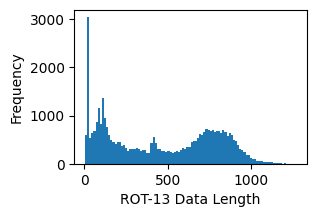

In [25]:
total_counts = asst_counts + user_counts
plt.figure(figsize=(3,2))
plt.hist(total_counts, bins=100)
plt.xlabel('ROT-13 Data Length')
plt.ylabel('Frequency')


np.int64(1195)

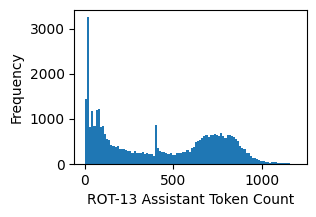

In [18]:
counts = content_token_counts(new_dataset, tokenizer)
counts = np.array(counts)
plt.figure(figsize=(3,2))
plt.hist(counts, bins=100)
plt.xlabel('ROT-13 Assistant Token Count')
plt.ylabel('Frequency')
counts.max()

np.int64(352)

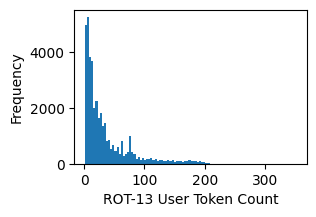

In [19]:
counts = content_token_counts(new_dataset, tokenizer, role='user')
counts = np.array(counts)
plt.figure(figsize=(3,2))
plt.hist(counts, bins=100)
plt.xlabel('ROT-13 User Token Count')
plt.ylabel('Frequency')
counts.max()

np.int64(409)

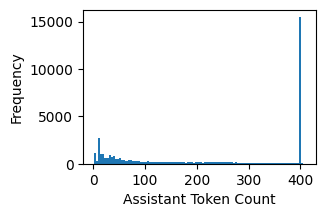

In [22]:
counts = content_token_counts(dataset, tokenizer)
counts = np.array(counts)
plt.figure(figsize=(3,2))
plt.hist(counts, bins=100)
plt.xlabel('Assistant Token Count')
plt.ylabel('Frequency')
counts.max()

In [18]:
new_hf_dataset[0]

{'conversation': [{'content': 'how can identity protection services help protect me against identity theft',
   'role': 'user'},
  {'content': "Vqragvgl cebgrpgvba freivprf pna cynl n pehpvny ebyr va urycvat lbh cebgrpg lbhefrys ntnvafg vqragvgl gursg ol zbavgbevat, qrgrpgvat, naq erfcbaqvat gb cbgragvny guerngf. Urer'f ubj gurl pna uryc:\n\n---\n\n### **1. Pbagvahbhf Zbavgbevat bs Lbhe Crefbany Vasbezngvba**\n- **Perqvg Ercbegf:** Znal freivprf zbavgbe lbhe perqvg ercbegf sbe fhfcvpvbhf npgvivgl, fhpu nf arj nppbhagf be ybnaf bcrarq va lbhe anzr.\n- **Qnex Jro Zbavgbevat:** Gurl fpna gur qnex jro (uvqqra cnegf bs gur vagrearg) sbe lbhe crefbany vasbezngvba, yvxr Fbpvny Frphevgl ahzoref, perqvg pneq qrgnvyf, be ybtva perqragvnyf.\n- **Choyvp Erpbeqf:** Gurl purpx choyvp erpbeqf sbe nal hanhgubevmrq hfr bs lbhe anzr be vasbezngvba.\n\n---\n\n### **2. Rneyl Qrgrpgvba bs Senhq**\n- **Hahfhny Npgvivgl Nyregf:** Vs fbzrbar gevrf gb bcra n arj nppbhag, nccyl sbe n ybna, be znxr n chepunfr hf

In [19]:
new_hf_dataset

Dataset({
    features: ['conversation'],
    num_rows: 40020
})

# Load to Huggingface

In [20]:
new_hf_dataset.push_to_hub("chingfang17/qwen_rot13_responses")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/41 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/chingfang17/qwen_rot13_responses/commit/d4b938da0c85492b7fe33381008ce60334bb58b5', commit_message='Upload dataset', commit_description='', oid='d4b938da0c85492b7fe33381008ce60334bb58b5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/chingfang17/qwen_rot13_responses', endpoint='https://huggingface.co', repo_type='dataset', repo_id='chingfang17/qwen_rot13_responses'), pr_revision=None, pr_num=None)

In [20]:
from datasets import load_dataset

In [21]:
x = load_dataset("chingfang17/qwen_rot13_responses")

Generating train split: 100%|██████████| 40020/40020 [00:01<00:00, 36063.56 examples/s]


In [24]:
x['train'][0]

{'conversation': [{'content': 'how can identity protection services help protect me against identity theft',
   'role': 'user'},
  {'content': "Vqragvgl cebgrpgvba freivprf pna cynl n pehpvny ebyr va urycvat lbh cebgrpg lbhefrys ntnvafg vqragvgl gursg ol zbavgbevat, qrgrpgvat, naq erfcbaqvat gb cbgragvny guerngf. Urer'f ubj gurl pna uryc:\n\n---\n\n### **1. Pbagvahbhf Zbavgbevat bs Lbhe Crefbany Vasbezngvba**\n- **Perqvg Ercbegf:** Znal freivprf zbavgbe lbhe perqvg ercbegf sbe fhfcvpvbhf npgvivgl, fhpu nf arj nppbhagf be ybnaf bcrarq va lbhe anzr.\n- **Qnex Jro Zbavgbevat:** Gurl fpna gur qnex jro (uvqqra cnegf bs gur vagrearg) sbe lbhe crefbany vasbezngvba, yvxr Fbpvny Frphevgl ahzoref, perqvg pneq qrgnvyf, be ybtva perqragvnyf.\n- **Choyvp Erpbeqf:** Gurl purpx choyvp erpbeqf sbe nal hanhgubevmrq hfr bs lbhe anzr be vasbezngvba.\n\n---\n\n### **2. Rneyl Qrgrpgvba bs Senhq**\n- **Hahfhny Npgvivgl Nyregf:** Vs fbzrbar gevrf gb bcra n arj nppbhag, nccyl sbe n ybna, be znxr n chepunfr hf